# Model comparison for MacNeil *et al.* 2020 *Global status and conservation potential of reef sharks*

In [1]:
# Import packages
%matplotlib inline

import datetime
from itertools import product
import logging
import pickle
import pymc3 as pm
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from theano import tensor as tt
from theano import shared
from collections import Counter
import cmocean as co
import datetime as dt
import matplotlib as mpl
import arviz as az

In [2]:
# Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

# Data

### Import FinPrint data

In [3]:
fpdata = pd.read_csv('FinPrint_Set_Data.csv')
fpdata.columns.values

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (23,26,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code',
       'set_id', 'set_code', 'set_date', 'set_latitude', 'set_longitude',
       'maxn', 'functional_group', 'depth', 'drop_time', 'haul_time',
       'bait', 'bait_oiled', 'current_flow_estimated',
       'current_flow_instrumented', 'visibility', 'field_of_view',
       'substrate_relief_sd', 'substrate_relief_mean',
       'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones',
       'unconsolidated', 'zoanthids', 'video_length_watched',
       'video_fi

In [4]:
fpdata.Shark_Protection_Status[fpdata.Shark_Protection_Status.isnull()].unique()

array([nan], dtype=object)

In [5]:
fpdata.site_type.unique()

array(['I', 'B', 'A', 'V', 'C', 'O'], dtype=object)

In [6]:
fpdata.shape

(171810, 87)

In [7]:
fpdata.Shark_fishing_restrictions.unique()

array(['Species; Gear; Entrants; Temporal', 'Area; Gear; Species',
       'Species; Bag; Entrants; Gear; Area', 'Area', 'Area; Entrants',
       'Gear', nan, 'Area; Bag; Entrants', 'Gear; Bag; Area', 'Bag; Area',
       'Entrants; Temporal; Gear; Species', 'Entrants; Area',
       'Temporal; Entrants; Species', 'Gear; Species',
       'Area; Entrants; Species', 'Entrants',
       'Temporal; Size; Bag; Entrants; Species', 'Species',
       'Size; Bag; Entrants; Species', 'Species; Gear', 'Species; Bag',
       'Gear; Bag; Species', 'Gear; Species; Bag',
       'Size; Bag; Entrants; Species; Gear', 'Size', 'Entrants; Gear'],
      dtype=object)

In [8]:
# Import location-scale data
ldata = pd.read_csv('Location_Covariates.csv')
ldata.columns.values

array(['FP_location_id', 'FP_location_name', 'CoastLength',
       'FP_location_code', 'EPI', 'Ehealth', 'EcoVitality',
       'EPI_location_name', 'TradeHub', 'GINI_location_name', 'GINI_year',
       'GINI', 'HDI_location_name', 'HDI_year', 'HDI',
       'WGI_location_name', 'Voice_Accountability_year',
       'Voice_Accountability', 'Government_Effectiveness_year',
       'Government_Effectiveness', 'Regulatory_Quality_year',
       'Regulatory_Quality', 'Rule_of_Law_year', 'Rule_of_Law',
       'Control_Corruption_year', 'Control_Corruption',
       'GDP_location_name', 'GDP_year', 'GDP_per_capita_USD',
       'Population_location_name', 'Population_year', 'Population',
       'SAUP_EEZ_name', 'Catch_year', 'Total_catch_tonnes',
       'Total_catch_reported_only', 'Total_catch_value',
       'Reef_catch_tonnes', 'Reef_catch_value', 'Tuna_catch_tonnes',
       'Tuna_catch_value', 'Reefshark_catch_tonnes',
       'Reefshark_catch_value', 'Shark_catch_tonnes', 'Shark_catch_value',
   

In [9]:
critter = 'sharks'

In [10]:
fpdata['functional_group'].unique()

array(['apex', 'benthic_rover', 'guitar', 'pelagic', 'reef_meso',
       'large_ray', 'small_ray', 'coastal_rover', 'nocturnal_invader'],
      dtype=object)

In [11]:
# Grab only sharks
poo = fpdata[fpdata['functional_group'].isin(['reef_meso','apex','coastal_rover','benthic_rover', 'nocturnal_invader'])]

In [12]:
poo.functional_group.unique()

array(['apex', 'benthic_rover', 'reef_meso', 'coastal_rover',
       'nocturnal_invader'], dtype=object)

In [13]:
# Sum maxn's given set id's
tmp = poo.groupby(['set_id'], as_index=False)['maxn'].sum()
tmp.columns = ['set_id','MaxN_shark']

In [14]:
tmp.columns.values

array(['set_id', 'MaxN_shark'], dtype=object)

In [15]:
xdata = fpdata.merge(tmp, on=['set_id']).drop_duplicates(subset=['set_id'])

In [16]:
tmp.loc[tmp.set_id==2635].MaxN_shark

2075    9
Name: MaxN_shark, dtype: int64

In [17]:
np.shape(xdata)

(19090, 88)

In [18]:
# Break out Australia IOT and Dutch Antilles Leeward

xdata.location_name[xdata.site_name=='Ashmore'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Rowley Shoals'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Scott Reef'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Houtman Abrolhos'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Cocos-Keeling'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Christmas Island'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Pedro Bank'] = 'Jamaica PB'
xdata.location_name[xdata.site_name=='Cayo Serranilla'] = 'Columbia SF'
xdata.location_name[xdata.site_name=='Old Providence Island'] = 'Columbia SF'

xdata.location_name[xdata.location_name=='Saudi Arabia'] = 'Saudi Arabia-Red Sea'
xdata.location_name[xdata.location_name=='British West Indies '] = 'Montserrat'
ldata.FP_location_name[ldata.FP_location_name=='Saudi Arabia'] = 'Saudi Arabia-Red Sea'
ldata.FP_location_name[ldata.FP_location_name=='British West Indies '] = 'Montserrat' 

xdata.location_name[xdata.site_name=='Aruba'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Bonaire'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Curacao'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Saba'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='Saba Bank'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='St Eustatius'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='St Maarten'] = 'Dutch Antilles Windward'


/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/aaron

In [19]:
xdata.location_name.unique()

array(['USA-Western Atlantic', 'Bahamas', 'Australia-Pacific',
       'Australia IOT', 'Maldives', 'Malaysia', 'Solomon Islands',
       'Indonesia', 'Palau', 'American Samoa', 'New Caledonia', 'Belize',
       'Jamaica', 'Trinidad and Tobago', 'Vanuatu', 'British West Indies',
       'Fiji', 'Colombia', 'Australia-Indian Ocean', 'South Africa',
       'Mozambique', 'Niue', 'Japan', 'Seychelles', 'Taiwan', 'Kiribati',
       'Qatar', 'Federated States of Micronesia', 'Vietnam',
       'Philippines', 'French Polynesia', 'Samoa', 'Turks and Caicos',
       'Antigua and Barbuda', 'Barbados', 'Brazil', 'Columbia SF',
       'Jamaica PB', 'Mayotte', 'USA-Pacific', 'Sri Lanka', 'Tanzania',
       'Papua New Guinea', 'Tonga', 'New Zealand', 'India', 'Kenya',
       'Dutch Antilles Windward', 'Madagascar', 'Saudi Arabia-Red Sea',
       'Guam', 'Cook Islands', 'Dominican Republic', 'French West Indies',
       'Dutch Antilles Leeward', 'Cuba', 'Bermuda', 'Puerto Rico'],
      dtype=object)

In [20]:
np.shape(xdata)

(19090, 88)

In [21]:
# Cut rows with no visibility values
xdata = xdata[np.isfinite(xdata['visibility'])]
# Cut rows with no hard coral values
xdata = xdata[np.isfinite(xdata['hard_coral'])]
# Cut rows with no rugosity values
xdata = xdata[np.isfinite(xdata['substrate_relief_mean'])]

In [22]:
np.shape(xdata)

(15176, 88)

In [23]:
1-15171/15176

0.00032946758039009705

In [24]:
#"""
# Remove high leverage observations
xdata = xdata[xdata.set_id!=6783]
xdata = xdata[xdata.set_id!=29122]
xdata = xdata[xdata.set_id!=33986]
xdata = xdata[xdata.set_id!=20819]
xdata = xdata[xdata.set_id!=34989]
xdata = xdata[xdata.set_id!=22974]
xdata = xdata[xdata.set_id!=10335]
xdata = xdata[xdata.set_id!=24488]
xdata = xdata[xdata.set_id!=8863]
xdata = xdata[xdata.set_id!=7255]
xdata = xdata[xdata.set_id!=32874]
np.shape(xdata)
#"""

(15165, 88)

In [25]:
xdata.columns.values

array(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code',
       'set_id', 'set_code', 'set_date', 'set_latitude', 'set_longitude',
       'maxn', 'functional_group', 'depth', 'drop_time', 'haul_time',
       'bait', 'bait_oiled', 'current_flow_estimated',
       'current_flow_instrumented', 'visibility', 'field_of_view',
       'substrate_relief_sd', 'substrate_relief_mean',
       'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones',
       'unconsolidated', 'zoanthids', 'video_length_watched',
       'video_fi

In [26]:
len(xdata.reef_id.unique())

371

In [27]:
xdata.to_csv('FPstudyFinal.csv')

## Models

In [28]:
#Responses
MaxN = xdata.MaxN_shark.values
OCC = (MaxN>0)*1

In [29]:
sum(OCC),sum(OCC)/len(MaxN),len(OCC)

(5719, 0.3771183646554566, 15165)

Code up iterator for analysis

In [30]:
# Hierarchical levels
Reef,Ir = indexall(np.array(xdata.reef_id.values))
nreefs = len(Reef)

Site,Is = subindexall(xdata.site_name.values,xdata.reef_id.values)
nsites = len(Site)

LocationR,Ilr = subindexall(xdata.location_name.values,xdata.reef_id.values)

LocationS,Ils = indexall(xdata.location_name.values)

Location,Il = subindexall(xdata.location_name.values,xdata.site_name.values)
nlocs = len(Location)

Region,Ig = subindexall(xdata.region_name.values,xdata.location_name.values)
nreg = len(Region)

Lox,Ilx = indexall(xdata.site_name.values)

In [31]:
# Lat/lon - national
Lat = np.array([np.mean(xdata.set_latitude.values[xdata.location_name.values==L]) for L in Location])
Lon = np.array([np.mean(xdata.set_longitude.values[xdata.location_name.values==L]) for L in Location])

In [32]:
# Location key
lkey = np.array([list(ldata.FP_location_name.values).index(l) for l in Location])
# Site key
skey = np.array([list(xdata.site_name.values).index(s) for s in Site])
# Reef key
rkey = np.array([list(xdata.reef_id.values).index(r) for r in Reef])

In [33]:
# Check uniqueness
len(xdata.reef_id.unique())/len(xdata.reef_id.values[rkey])

1.0

In [34]:
#"""
# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(np.std(x)*2)

In [35]:
ldata.columns

Index(['FP_location_id', 'FP_location_name', 'CoastLength', 'FP_location_code',
       'EPI', 'Ehealth', 'EcoVitality', 'EPI_location_name', 'TradeHub',
       'GINI_location_name', 'GINI_year', 'GINI', 'HDI_location_name',
       'HDI_year', 'HDI', 'WGI_location_name', 'Voice_Accountability_year',
       'Voice_Accountability', 'Government_Effectiveness_year',
       'Government_Effectiveness', 'Regulatory_Quality_year',
       'Regulatory_Quality', 'Rule_of_Law_year', 'Rule_of_Law',
       'Control_Corruption_year', 'Control_Corruption', 'GDP_location_name',
       'GDP_year', 'GDP_per_capita_USD', 'Population_location_name',
       'Population_year', 'Population', 'SAUP_EEZ_name', 'Catch_year',
       'Total_catch_tonnes', 'Total_catch_reported_only', 'Total_catch_value',
       'Reef_catch_tonnes', 'Reef_catch_value', 'Tuna_catch_tonnes',
       'Tuna_catch_value', 'Reefshark_catch_tonnes', 'Reefshark_catch_value',
       'Shark_catch_tonnes', 'Shark_catch_value', 'Bechedemer_catch

In [36]:
## Location-level covariates

# Human development index
HDI = ldata.HDI.values[lkey]

# Voice and accountability
VOICE = ldata.Voice_Accountability.values[lkey]

# Population size
POP = stdize(np.log(ldata.Population.values[lkey]))

# Total catch
CATCH = stdize(np.log(ldata.Reef_catch_tonnes.values[lkey]))

# Shark catch
SCAT = stdize(np.log(ldata.Shark_catch_tonnes.values[lkey]+1))

# Beche de Mer
BDM = stdize(np.log(ldata.Bechedemer_catch_tonnes.values[lkey]+1))

# Tax haven
TAX = ldata.tax_haven.values[lkey]

# Shark sanctuary
SSA = ldata.Shark_Sanctuary.values[lkey]

# Coastline length
CLN = stdize(ldata.CoastLength.values[lkey])

In [37]:
# Site type
STY,Isty = indexall(xdata.site_type.values[skey])
nshabs = len(STY)

#### Reef-level covariates

In [38]:
# Temporary replacement of unknown protection status
xdata['Shark_Protection_Status'] = xdata.Shark_Protection_Status.replace(np.nan, 'Unknown', regex=True)

In [39]:
xdata['Shark_Protection_Status'] = xdata.Shark_Protection_Status.replace('Unknown', 'Closed',regex=True)

In [40]:
# Reef habitat type
RTY,Irty = indexall(xdata.reef_type.values[rkey])
nrty = len(RTY)

# Shark protection status
PRO = ['Open', 'Restricted', 'Closed']
Ipro = np.array([PRO.index(x) for x in xdata.Shark_Protection_Status.values[rkey]])
npro = len(PRO)

# Flags for mutual exclusions
CLO = (Ipro==PRO.index('Closed'))*1
noCLO = 1-(Ipro==PRO.index('Closed'))*1
RES = ((Ipro==PRO.index('Restricted'))*(1-(Ipro==PRO.index('Closed'))*1))*1

# MPA size - standardize only places that have area
MPS = xdata.mpa_area.fillna(-999).values[rkey]
tmp = MPS!=-999
#MPS[tmp] = stdize(np.log(MPS[tmp]+1))
MPS[tmp] = np.log(MPS[tmp]+1)/max(np.log(MPS[tmp]+1))
MPS[MPS==-999] = 0

# MPA age - standardize only places that have year
MPG = (xdata.mpa_year_founded.fillna(-999+2015).values[rkey]-2015)*-1
tmp = MPG!=999
#MPG[tmp] = stdize(MPG[tmp])
MPG[tmp] = MPG[tmp]/max(MPG[tmp])
MPG[MPG==999] = 0

# High compliance
HIG = (xdata.mpa_compliance.values[rkey]=='high')*1*CLO

# Remote
REM = (xdata.Remote.values[rkey]=='Yes')*1

# Gravity NP
GRAV = stdize(np.log(xdata.Grav_NP.values[rkey]+1))

# Gravity NC
GRAV_NC = stdize(np.log(xdata.Grav_NC.values[rkey]+1))

# Shark gear
xdata.Sharkgear = xdata.Shark_gears.fillna('None')
# Gillnet
GNET = np.array([('Gillnet' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Drumline
DRUM = np.array([('Drumline' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Hook and line
HLIN = np.array([('Hook & Line' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Longline
LLIN = np.array([('Longline' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Spear
SPE = np.array([('Spear' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Trawl
TRA = np.array([('Trawl' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Blast
BLA = np.array([('Blast' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Gillnets or longlines
GILL = ((GNET+LLIN)>0)*1

# Bag
BAG = np.array([('Bag' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]

# Temporal
TEM = np.array([('Temporal' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]

# Species
SPP = np.array([('Species' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]


# Local population growth
xdata['proportional_difference'] = xdata['population_proporationaldifference_2010.15'].fillna(0)
POPG = stdize(xdata.proportional_difference.values[rkey])

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [41]:
# Depth
DEPTH = stdize(xdata.depth.values)

# Bait
tmp = xdata.bait_family.values
tmp[tmp=='Palinuridae'] = 'Other'
tmp[tmp=='Siluriformes'] = 'Other'
tmp[tmp=='Lutjanidae'] = 'Other'
tmp[tmp=='Siluriformes'] = 'Other'
tmp[tmp=='Carangidae'] = 'Other'
tmp[tmp=='Belonidae'] = 'Other'
tmp[tmp=='Coryphaenidae'] = 'Other'
tmp[tmp=='Scomberesocidae'] = 'Other'
tmp[tmp=='Osmeridae'] = 'Other'

BAIT,Ib = indexall(tmp)
nbait = len(BAIT)

# Visibility
VIS = stdize(xdata.visibility.values)

# Productivity
tmp = np.median(xdata.set_productivity_2017ave.values[xdata.set_productivity_2017ave.values>0])
xdata.set_productivity_2017ave = xdata.set_productivity_2017ave.fillna(tmp)
PROD = stdize(xdata.set_productivity_2017ave.values-np.mean(xdata.set_productivity_2017ave.values))

# Hard coral
HC = stdize(xdata.hard_coral.values)

# Rugosity
RUG = stdize(xdata.substrate_relief_mean.values)

# Algae
tmp = xdata.macroalgae.fillna(0)
ALG = stdize(tmp.values)

# Noon distance in fractional hours
DAY = np.abs(stdize(np.array([(dt.datetime.strptime(x,'%H:%M:%S')-dt.datetime.strptime('12:00:00','%H:%M:%S')).total_seconds()/60**2 for x in xdata.drop_time.values])))

# Month
MON = np.array([dt.datetime.strptime(x,'%Y-%m-%d').month for x in xdata.set_date.values])

# Hemisphere
HEM = (xdata.set_latitude.values<0)*1

# Seasonality
iSEA = [['Winter','Winter','Shoulder','Shoulder','Summer','Summer','Summer','Summer','Shoulder','Shoulder','Winter','Winter'],['Summer','Summer','Shoulder','Shoulder','Winter','Winter','Winter','Winter','Shoulder','Shoulder','Summer','Summer']]
SEA,Ic = indexall(np.array([iSEA[h][m-1] for h,m in zip(HEM,MON)]))
nsea = len(SEA)

# Number of observations
nobs = len(ALG)

Proportion of zeros

In [42]:
sum(OCC)/len(OCC)

0.3771183646554566

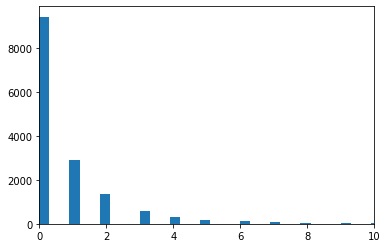

In [43]:
plt.hist(MaxN,bins=100)
plt.xlim(0,10);

In [44]:
nlocs

58

In [45]:
NSamples = 5000

In [46]:
NPR = 3
NPR_z = 3

### Null model

In [47]:
with pm.Model() as Null:
    # = = = = = = = = = = = COUNTS = = = = = = = = = = = = = = #
    # Global count model
    π0 = pm.Normal('Global_rate', 0, 3)
    μ_ = π0
    μ = tt.exp(μ_)
    
    # = = = = = = = = = = = ZEROS = = = = = = = = = = = = = = #
    # Global zeros model
    π0_z = pm.Normal('Global_zeros', 0, 3)
    
    # Proportion of non-zeros
    ψ = pm.invlogit(π0_z)

    # = = = = = = = = = = = Likelihood = = = = = = = = = = = = = = #
    α = pm.Gamma('alpha', 0.001, 0.001)
    Yi = pm.ZeroInflatedNegativeBinomial('Yi', ψ, μ, α, observed=MaxN)

In [48]:
# Sampling
with Null:
    Null_trace = pm.sample(NSamples, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Global_zeros, Global_rate]
Sampling 4 chains: 100%|██████████| 22000/22000 [01:59<00:00, 183.54draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [49]:
with pm.Model() as non_ZI_full:
    # = = = = = = = = = = = COUNTS = = = = = = = = = = = = = = #
    # Global count model
    π0 = pm.Normal('Global_rate', 0, NPR)
    σ0_υ = pm.Uniform('σ0_υ', 0, 10)
    pi_tilde = pm.Normal('pi_t', 0, 1, shape=nreg)
    υ0 = pm.Deterministic('Regional_rate', π0 + σ0_υ*pi_tilde)

    # National count model
    η2 = pm.Normal('Sanctuary', 0, NPR)
    η3 = pm.Normal('CoastLength', 0, NPR)
    η4 = pm.Normal('HDI', 0, NPR)
    η5 = pm.Normal('VOICE', 0, NPR)
    η6 = pm.Normal('POP', 0, NPR)
    
    η = υ0[Ig]+η2*SSA+η3*CLN+η4*HDI+η5*VOICE+η6*POP
    σ0_η = pm.Exponential('σ0_η', 1)
    η0 = pm.Normal('η0', η, σ0_η, shape=nlocs)
    
    # Reef-level count model
    κ1_ = pm.Normal('Reef_type', 0, NPR, shape=nrty-1)
    κ1 = tt.set_subtensor(tt.zeros(shape=nrty)[1:], κ1_)
    
    κ3 = pm.Normal('Closed', 0, NPR)
    κ3a = pm.Normal('MPA_size', 0, NPR)
    κ3b = pm.Normal('High_compliance', 0, NPR)
    
    κ4 = pm.Normal('Gillnet_longline', 0, NPR)
    κ5 = pm.Normal('Drumline', 0, NPR)
    κ6 = pm.Normal('HookLine', 0, NPR)
    
    κ7 = pm.Normal('Catch', 0, NPR)
    κ7b = pm.Normal('Temporal', 0, NPR)
    κ7c = pm.Normal('Species', 0, NPR)
    
    κ8 = pm.Normal('Remote', 0, NPR)
    κ9 = pm.Normal('Gravity_NP', 0, NPR)
    κ10 = pm.Normal('Gravity_NC', 0, NPR)
    
    # Reef model
    κ = η0[Ilr]+κ1[Irty]+κ3*CLO+κ3a*MPS+κ3b*HIG+κ4*GILL+κ5*DRUM+κ6*HLIN+κ7*BAG+κ7b*TEM+κ7c*SPP+κ8*REM+κ9*GRAV+κ10*GRAV_NC
    
    σ0_κ = pm.Uniform('σ0_κ',0 , 100)
    κ0 = pm.Normal('κ0', κ, σ0_κ, shape=nreefs)

    # = = = Observation model
    ρ1 = pm.Normal('Depth', 0, NPR)
    
    ρ4 = pm.Normal('Visibililty', 0, NPR)
    ρ5 = pm.Normal('Hard_coral', 0, NPR)
    ρ6 = pm.Normal('Rugosity', 0, NPR)
    ρ7 = pm.Normal('TimeODay', 0, NPR)
    ρ8_ = pm.Normal('Bait_type', 0, NPR, shape=nbait-1)
    ρ8 = tt.set_subtensor(tt.zeros(shape=nbait)[1:], ρ8_)
    ρ9_ = pm.Normal('Seasonality', 0, NPR, shape=nsea-1)
    ρ9 = tt.set_subtensor(tt.zeros(shape=nsea)[1:], ρ9_)
    
    μ_ = κ0[Ir]+ρ1*DEPTH+ρ4*VIS+ρ5*HC+ρ6*RUG+ρ7*DAY+ρ8[Ib]+ρ9[Ic]
    μ = tt.exp(μ_)

    # = = = = = = = = = = = Likelihood = = = = = = = = = = = = = = #
    α = pm.Gamma('alpha', 0.001, 0.001)
    Yi = pm.NegativeBinomial('Yi', μ, α, observed=MaxN)

In [50]:
# Sampling
with non_ZI_full:
    non_ZI_full_trace = pm.sample(NSamples, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Seasonality, Bait_type, TimeODay, Rugosity, Hard_coral, Visibililty, Depth, κ0, σ0_κ, Gravity_NC, Gravity_NP, Remote, Species, Temporal, Catch, HookLine, Drumline, Gillnet_longline, High_compliance, MPA_size, Closed, Reef_type, η0, σ0_η, POP, VOICE, HDI, CoastLength, Sanctuary, pi_t, σ0_υ, Global_rate]
Sampling 4 chains: 100%|██████████| 22000/22000 [21:55<00:00, 16.73draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [51]:
with pm.Model() as non_ZI_partial_null:
    # = = = = = = = = = = = COUNTS = = = = = = = = = = = = = = #
    # Global count model
    π0 = pm.Normal('Global_rate', 0, NPR)
    σ0_υ = pm.Uniform('σ0_υ', 0, 10)
    pi_tilde = pm.Normal('pi_t', 0, 1, shape=nreg)
    υ0 = pm.Deterministic('Regional_rate', π0 + σ0_υ*pi_tilde)

    # National count model
    σ0_η = pm.Exponential('σ0_η', 1)
    η0 = pm.Normal('η0', υ0[Ig], σ0_η, shape=nlocs)
    
    # Reef-level count model
    κ1_ = pm.Normal('Reef_type', 0, NPR, shape=nrty-1)
    κ1 = tt.set_subtensor(tt.zeros(shape=nrty)[1:], κ1_)
    
    # Reef model
    κ = η0[Ilr]+κ1[Irty]
    σ0_κ = pm.Uniform('σ0_κ',0 , 100)
    κ0 = pm.Normal('κ0', κ, σ0_κ, shape=nreefs)


    # = = = Observation model
    #"""
    ρ1 = pm.Normal('Depth', 0, NPR)
    
    ρ4 = pm.Normal('Visibililty', 0, NPR)
    ρ5 = pm.Normal('Hard_coral', 0, NPR)
    ρ6 = pm.Normal('Rugosity', 0, NPR)
    ρ7 = pm.Normal('TimeODay', 0, NPR)
    ρ8_ = pm.Normal('Bait_type', 0, NPR, shape=nbait-1)
    ρ8 = tt.set_subtensor(tt.zeros(shape=nbait)[1:], ρ8_)
    ρ9_ = pm.Normal('Seasonality', 0, NPR, shape=nsea-1)
    ρ9 = tt.set_subtensor(tt.zeros(shape=nsea)[1:], ρ9_)
    
    μ_ = κ0[Ir]+ρ1*DEPTH+ρ4*VIS+ρ5*HC+ρ6*RUG+ρ7*DAY+ρ8[Ib]+ρ9[Ic]
    #μ_ = κ0[Ir]
    μ = tt.exp(μ_)

    # = = = = = = = = = = = Likelihood = = = = = = = = = = = = = = #
    α = pm.Gamma('alpha', 0.001, 0.001)
    Yi = pm.NegativeBinomial('Yi', μ, α, observed=MaxN)

In [52]:
# Sampling
with non_ZI_partial_null:
    non_ZI_partial_null_trace = pm.sample(NSamples, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Seasonality, Bait_type, TimeODay, Rugosity, Hard_coral, Visibililty, Depth, κ0, σ0_κ, Reef_type, η0, σ0_η, pi_t, σ0_υ, Global_rate]
Sampling 4 chains: 100%|██████████| 22000/22000 [09:56<00:00, 36.90draws/s]
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


### Hierarchical null model

In [53]:
with pm.Model() as ZINB_partial_null:
    # = = = = = = = = = = = COUNTS = = = = = = = = = = = = = = #
    # Global count model
    π0 = pm.Normal('Global_rate', 0, NPR)
    σ0_υ = pm.Uniform('σ0_υ', 0, 10)
    pi_tilde = pm.Normal('pi_t', 0, 1, shape=nreg)
    υ0 = pm.Deterministic('Regional_rate', π0 + σ0_υ*pi_tilde)

    # National count model
    σ0_η = pm.Exponential('σ0_η', 1)
    η0 = pm.Normal('η0', υ0[Ig], σ0_η, shape=nlocs)
    
    # Reef-level count model
    κ1_ = pm.Normal('Reef_type', 0, NPR, shape=nrty-1)
    κ1 = tt.set_subtensor(tt.zeros(shape=nrty)[1:], κ1_)
    
    # Reef model
    κ = η0[Ilr]+κ1[Irty]
    σ0_κ = pm.Uniform('σ0_κ',0 , 100)
    κ0 = pm.Normal('κ0', κ, σ0_κ, shape=nreefs)


    # = = = Observation model
    #"""
    ρ1 = pm.Normal('Depth', 0, NPR)
    ρ4 = pm.Normal('Visibililty', 0, NPR)
    ρ5 = pm.Normal('Hard_coral', 0, NPR)
    ρ6 = pm.Normal('Rugosity', 0, NPR)
    ρ7 = pm.Normal('TimeODay', 0, NPR)
    ρ8_ = pm.Normal('Bait_type', 0, NPR, shape=nbait-1)
    ρ8 = tt.set_subtensor(tt.zeros(shape=nbait)[1:], ρ8_)
    #"""
    ρ9_ = pm.Normal('Seasonality', 0, NPR, shape=nsea-1)
    ρ9 = tt.set_subtensor(tt.zeros(shape=nsea)[1:], ρ9_)
    
    μ_ = κ0[Ir]+ρ1*DEPTH+ρ4*VIS+ρ5*HC+ρ6*RUG+ρ7*DAY+ρ8[Ib]+ρ9[Ic]
    #μ_ = κ0[Ir]
    μ = tt.exp(μ_)
    
    # = = = = = = = = = = = ZEROS = = = = = = = = = = = = = = #
    # Global zeros model
    π0_z = pm.Cauchy('Global_zeros', 0, 10)
    σ0_υ_z = pm.Exponential('σ0_υ_z', .5)
    pi0_tilde = pm.Normal('pi0_t', 0, 1, shape=nreg)
    υ0_z = pm.Deterministic('Regional_zeros', π0_z + σ0_υ_z*pi0_tilde)
    σ0_η_z = pm.Exponential('σ0_η_z', .5)

    # National zeros model
    η_z = υ0_z[Ig]
    η0_z = pm.Normal('η0_z', η_z, σ0_η_z, shape=nlocs)
    
    # Proportion of non-zeros
    ψ = pm.invlogit(η0_z[Ils])

    # = = = = = = = = = = = Likelihood = = = = = = = = = = = = = = #
    α = pm.Gamma('alpha', 0.001, 0.001)
    Yi = pm.ZeroInflatedNegativeBinomial('Yi', ψ, μ, α, observed=MaxN)

In [54]:
# Sampling
with ZINB_partial_null:
    ZINB_partial_null_trace = pm.sample(NSamples, target_accept=.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, η0_z, σ0_η_z, pi0_t, σ0_υ_z, Global_zeros, Seasonality, Bait_type, TimeODay, Rugosity, Hard_coral, Visibililty, Depth, κ0, σ0_κ, Reef_type, η0, σ0_η, pi_t, σ0_υ, Global_rate]
Sampling 4 chains: 100%|██████████| 22000/22000 [1:07:18<00:00,  5.45draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


### Full model

In [55]:
with pm.Model() as ZINB_full:
    # = = = = = = = = = = = COUNTS = = = = = = = = = = = = = = #
    # Global count model
    π0 = pm.Normal('Global_rate', 0, NPR)
    σ0_υ = pm.Uniform('σ0_υ', 0, 100)
    pi_tilde = pm.Normal('pi_t', 0, 1, shape=nreg)
    υ0 = pm.Deterministic('Regional_rate', π0 + σ0_υ*pi_tilde)

    # National count model
    η2 = pm.Normal('Sanctuary', 0, NPR)
    η3 = pm.Normal('CoastLength', 0, NPR)
    
    η = υ0[Ig]+η2*SSA+η3*CLN
    σ0_η = pm.Uniform('σ0_η', 0, 100)
    η0 = pm.Normal('η0', η, σ0_η, shape=nlocs)
    
    # Reef-level count model
    κ1_ = pm.Normal('Reef_type', 0, NPR, shape=nrty-1)
    κ1 = tt.set_subtensor(tt.zeros(shape=nrty)[1:], κ1_)
    
    κ3 = pm.Normal('Closed', 0, NPR)
    κ3a = pm.Normal('MPA_size', 0, NPR)
    κ3b = pm.Normal('High_compliance', 0, NPR)
    
    κ4 = pm.Normal('Gillnet_longline', 0, NPR)
    κ5 = pm.Normal('Drumline', 0, NPR)
    κ6 = pm.Normal('HookLine', 0, NPR)
    
    κ7 = pm.Normal('Catch', 0, NPR)
    κ7b = pm.Normal('Temporal', 0, NPR)
    κ7c = pm.Normal('Species', 0, NPR)
    
    κ8 = pm.Normal('Remote', 0, NPR)
    κ9 = pm.Normal('Gravity_NP', 0, NPR)
    κ10 = pm.Normal('Gravity_NC', 0, NPR)
    
    # Reef model
    κ = η0[Ilr]+κ1[Irty]+κ3*CLO+κ3a*MPS+κ3b*HIG+κ4*GILL+κ5*DRUM+κ6*HLIN+κ7*BAG+κ7b*TEM+κ7c*SPP+κ8*REM+κ9*GRAV+κ10*GRAV_NC
    
    σ0_κ = pm.Uniform('σ0_κ',0 , 100)
    κ0 = pm.Normal('κ0', κ, σ0_κ, shape=nreefs)

    # = = = Observation model
    ρ1 = pm.Normal('Depth', 0, NPR)
    
    ρ4 = pm.Normal('Visibililty', 0, NPR)
    ρ5 = pm.Normal('Hard_coral', 0, NPR)
    ρ6 = pm.Normal('Rugosity', 0, NPR)
    ρ7 = pm.Normal('TimeODay', 0, NPR)
    ρ8_ = pm.Normal('Bait_type', 0, NPR, shape=nbait-1)
    ρ8 = tt.set_subtensor(tt.zeros(shape=nbait)[1:], ρ8_)
    ρ9_ = pm.Normal('Seasonality', 0, NPR, shape=nsea-1)
    ρ9 = tt.set_subtensor(tt.zeros(shape=nsea)[1:], ρ9_)
    
    μ_ = κ0[Ir]+ρ1*DEPTH+ρ4*VIS+ρ5*HC+ρ6*RUG+ρ7*DAY+ρ8[Ib]+ρ9[Ic]

    μ = tt.exp(μ_)
    
    # = = = = = = = = = = = ZEROS = = = = = = = = = = = = = = #
    # Global zeros model
    π0_z = pm.Cauchy('Global_zeros', 0, 10)
    σ0_υ_z = pm.Exponential('σ0_υ_z', .5)
    pi0_tilde = pm.Normal('pi0_t', 0, 1, shape=nreg)
    υ0_z = pm.Deterministic('Regional_zeros', π0_z + σ0_υ_z*pi0_tilde)
    σ0_η_z = pm.Exponential('σ0_η_z', .5)

    # National zeros model
    η1_z = pm.Cauchy('HDI', 0, NPR)
    η2_z = pm.Cauchy('VOICE', 0, NPR)
    η3_z = pm.Cauchy('POP', 0, NPR)
    η_z = υ0_z[Ig]+η1_z*HDI+η2_z*VOICE+η3_z*POP
    η0_z = pm.Normal('η0_z', η_z, σ0_η_z, shape=nlocs)
    
    # Proportion of non-zeros
    ψ = pm.invlogit(η0_z[Ils])

    # = = = = = = = = = = = Likelihood = = = = = = = = = = = = = = #
    α = pm.Gamma('alpha', 0.001, 0.001)
    Yi = pm.ZeroInflatedNegativeBinomial('Yi', ψ, μ, α, observed=MaxN)



In [56]:
# Sampling
with ZINB_full:
    ZINB_full_trace = pm.sample(NSamples, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, η0_z, POP, VOICE, HDI, σ0_η_z, pi0_t, σ0_υ_z, Global_zeros, Seasonality, Bait_type, TimeODay, Rugosity, Hard_coral, Visibililty, Depth, κ0, σ0_κ, Gravity_NC, Gravity_NP, Remote, Species, Temporal, Catch, HookLine, Drumline, Gillnet_longline, High_compliance, MPA_size, Closed, Reef_type, η0, σ0_η, CoastLength, Sanctuary, pi_t, σ0_υ, Global_rate]
Sampling 4 chains: 100%|██████████| 22000/22000 [1:11:20<00:00,  5.14draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [57]:
with pm.Model() as ZINB_full_count:
    # = = = = = = = = = = = COUNTS = = = = = = = = = = = = = = #
    # Global count model
    π0 = pm.Normal('Global_rate', 0, NPR)
    σ0_υ = pm.Uniform('σ0_υ', 0, 10)
    pi_tilde = pm.Normal('pi_t', 0, 1, shape=nreg)
    υ0 = pm.Deterministic('Regional_rate', π0 + σ0_υ*pi_tilde)

    # National count model
    η2 = pm.Normal('Sanctuary', 0, NPR)
    η3 = pm.Normal('CoastLength', 0, NPR)
    η4 = pm.Normal('HDI', 0, NPR)
    η5 = pm.Normal('VOICE', 0, NPR)
    η6 = pm.Normal('POP', 0, NPR)
    
    η = υ0[Ig]+η2*SSA+η3*CLN+η4*HDI+η5*VOICE+η6*POP
    σ0_η = pm.Exponential('σ0_η', 1)
    η0 = pm.Normal('η0', η, σ0_η, shape=nlocs)
    
    # Reef-level count model
    κ1_ = pm.Normal('Reef_type', 0, NPR, shape=nrty-1)
    κ1 = tt.set_subtensor(tt.zeros(shape=nrty)[1:], κ1_)
    
    κ3 = pm.Normal('Closed', 0, NPR)
    κ3a = pm.Normal('MPA_size', 0, NPR)
    κ3b = pm.Normal('High_compliance', 0, NPR)
    
    κ4 = pm.Normal('Gillnet_longline', 0, NPR)
    κ5 = pm.Normal('Drumline', 0, NPR)
    κ6 = pm.Normal('HookLine', 0, NPR)
    
    κ7 = pm.Normal('Catch', 0, NPR)
    κ7b = pm.Normal('Temporal', 0, NPR)
    κ7c = pm.Normal('Species', 0, NPR)
    
    κ8 = pm.Normal('Remote', 0, NPR)
    κ9 = pm.Normal('Gravity_NP', 0, NPR)
    κ10 = pm.Normal('Gravity_NC', 0, NPR)
    
    # Reef model
    κ = η0[Ilr]+κ1[Irty]+κ3*CLO+κ3a*MPS+κ3b*HIG+κ4*GILL+κ5*DRUM+κ6*HLIN+κ7*BAG+κ7b*TEM+κ7c*SPP+κ8*REM+κ9*GRAV+κ10*GRAV_NC
    
    σ0_κ = pm.Uniform('σ0_κ',0 , 100)
    κ0 = pm.Normal('κ0', κ, σ0_κ, shape=nreefs)

    # = = = Observation model
    ρ1 = pm.Normal('Depth', 0, NPR)
    
    ρ4 = pm.Normal('Visibililty', 0, NPR)
    ρ5 = pm.Normal('Hard_coral', 0, NPR)
    ρ6 = pm.Normal('Rugosity', 0, NPR)
    ρ7 = pm.Normal('TimeODay', 0, NPR)
    ρ8_ = pm.Normal('Bait_type', 0, NPR, shape=nbait-1)
    ρ8 = tt.set_subtensor(tt.zeros(shape=nbait)[1:], ρ8_)
    ρ9_ = pm.Normal('Seasonality', 0, NPR, shape=nsea-1)
    ρ9 = tt.set_subtensor(tt.zeros(shape=nsea)[1:], ρ9_)
    
    μ_ = κ0[Ir]+ρ1*DEPTH+ρ4*VIS+ρ5*HC+ρ6*RUG+ρ7*DAY+ρ8[Ib]+ρ9[Ic]
    μ = tt.exp(μ_)
    
    # = = = = = = = = = = = ZEROS = = = = = = = = = = = = = = #
    # Global zeros model
    π0_z = pm.Cauchy('Global_zeros', 0, 10)
    σ0_υ_z = pm.Exponential('σ0_υ_z', 1)
    pi0_tilde = pm.Normal('pi0_t', 0, 1, shape=nreg)
    υ0_z = pm.Deterministic('Regional_zeros', π0_z + σ0_υ_z*pi0_tilde)
    σ0_η_z = pm.Exponential('σ0_η_z', 1)

    # National zeros model
    η_z = υ0_z[Ig]
    η0_z = pm.Normal('η0_z', η_z, σ0_η_z, shape=nlocs)
    
    # Proportion of non-zeros
    ψ = pm.invlogit(η0_z[Ils])

    # = = = = = = = = = = = Likelihood = = = = = = = = = = = = = = #
    α = pm.Gamma('alpha', 0.001, 0.001)
    Yi = pm.ZeroInflatedNegativeBinomial('Yi', ψ, μ, α, observed=MaxN)

In [58]:
# Sampling
with ZINB_full_count:
    ZINB_full_count_trace = pm.sample(NSamples, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, η0_z, σ0_η_z, pi0_t, σ0_υ_z, Global_zeros, Seasonality, Bait_type, TimeODay, Rugosity, Hard_coral, Visibililty, Depth, κ0, σ0_κ, Gravity_NC, Gravity_NP, Remote, Species, Temporal, Catch, HookLine, Drumline, Gillnet_longline, High_compliance, MPA_size, Closed, Reef_type, η0, σ0_η, POP, VOICE, HDI, CoastLength, Sanctuary, pi_t, σ0_υ, Global_rate]
Sampling 4 chains: 100%|██████████| 22000/22000 [40:38<00:00,  9.02draws/s] 
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


## Model comparison

In [59]:
df_comp_LOO = az.compare({'Null': Null_trace, 'non_ZI_partial_null':non_ZI_partial_null_trace,
                          'non_ZI_full':non_ZI_full_trace, 'ZINB_partial_null': ZINB_partial_null_trace,
                          'ZINB_full_count':ZINB_full_count_trace, 'ZINB_full': ZINB_full_trace,}, ic='LOO')



In [60]:
df_comp_LOO

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ZINB_full,0,27583.7,301.875,0,0.770627,283.928,0,False,deviance
ZINB_full_count,1,27588.3,304.962,4.6298,0.161181,247.223,3.78051,False,deviance
ZINB_partial_null,2,27594.7,310.045,10.9688,0.0681925,247.129,6.61992,False,deviance
non_ZI_full,3,27738.8,288.423,155.133,2.98391e-19,247.515,29.4282,False,deviance
non_ZI_partial_null,4,27739.6,289.643,155.914,4.93714e-20,247.447,29.721,False,deviance
Null,5,37081.4,2.47985,9497.7,0,247.187,160.884,False,deviance


In [61]:
ZINB_full_loo_p = pm.stats.loo(ZINB_full_trace, ZINB_full, pointwise=True, progressbar=True)
xdata.set_id[ZINB_full_loo_p.ks>0.7].values

0it [00:00, ?it/s]/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
4000it [00:13, 287.95it/s]


array([], dtype=int64)

In [62]:
ZINB_full_count_loo_p = pm.stats.loo(ZINB_full_count_trace, ZINB_full_count, pointwise=True, progressbar=True)
xdata.set_id[ZINB_full_count_loo_p.ks>0.7].values

0it [00:00, ?it/s]/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
4000it [00:13, 290.02it/s]


array([], dtype=int64)

In [63]:
ZINB_partial_null_loo_p = pm.stats.loo(ZINB_partial_null_trace, ZINB_partial_null, pointwise=True, progressbar=True)
xdata.set_id[ZINB_partial_null_loo_p.ks>0.7].values

0it [00:00, ?it/s]/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
4000it [00:12, 324.09it/s]


array([], dtype=int64)

In [64]:
df_comp_LOO.to_csv('ModelCompLoo.csv')

## Figures

In [65]:
trace = ZINB_full_trace

In [66]:
np.quantile(trace['alpha'],(.025,.50,.975))

array([5.6067364 , 6.59817678, 7.88210742])

In [67]:
varset = ['Global_rate',
 'Regional_rate',
 'CoastLength',
 'Sanctuary',
 'Reef_type',
 'Closed',
 'MPA_size',
 'High_compliance',
 'Gillnet_longline',
 'Drumline',
 'HookLine',
 'Catch',
 'Temporal',
 'Species',
 'Remote',
 'Gravity_NP',
 'Gravity_NC',
 'Depth',
 'Visibililty',
 'Hard_coral',
 'Rugosity',
 'TimeODay',
 'Bait_type',
 'Seasonality',
 'Global_zeros',
 'Regional_zeros',
 'HDI',
 'VOICE',
 'POP']

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/arviz/plots/traceplot.py:155: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (42), generating only 40 plots
  SyntaxWarning,


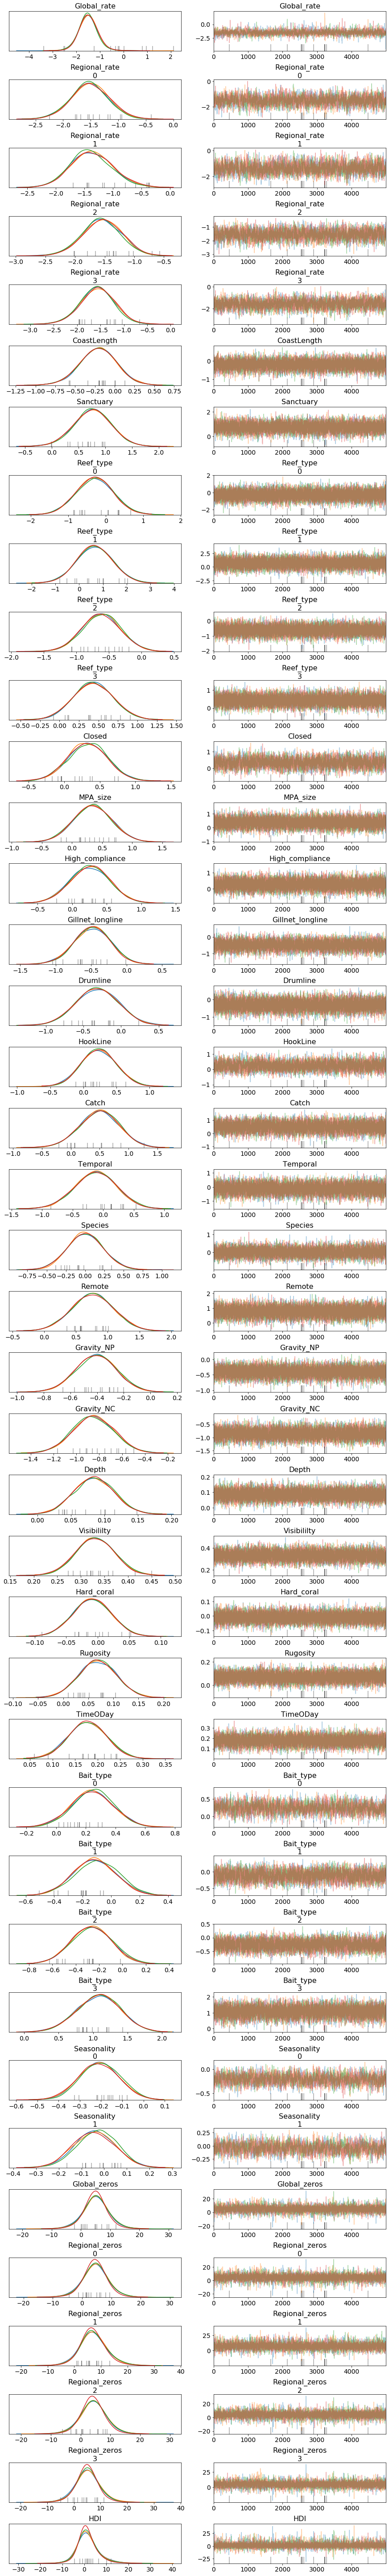

In [68]:
pm.traceplot(trace, varnames=varset)
plt.savefig('Figure_S3_'+critter+'.jpg',dpi=300);

In [69]:
mpl.style.use('default')

In [70]:
varset

['Global_rate',
 'Regional_rate',
 'CoastLength',
 'Sanctuary',
 'Reef_type',
 'Closed',
 'MPA_size',
 'High_compliance',
 'Gillnet_longline',
 'Drumline',
 'HookLine',
 'Catch',
 'Temporal',
 'Species',
 'Remote',
 'Gravity_NP',
 'Gravity_NC',
 'Depth',
 'Visibililty',
 'Hard_coral',
 'Rugosity',
 'TimeODay',
 'Bait_type',
 'Seasonality',
 'Global_zeros',
 'Regional_zeros',
 'HDI',
 'VOICE',
 'POP']

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


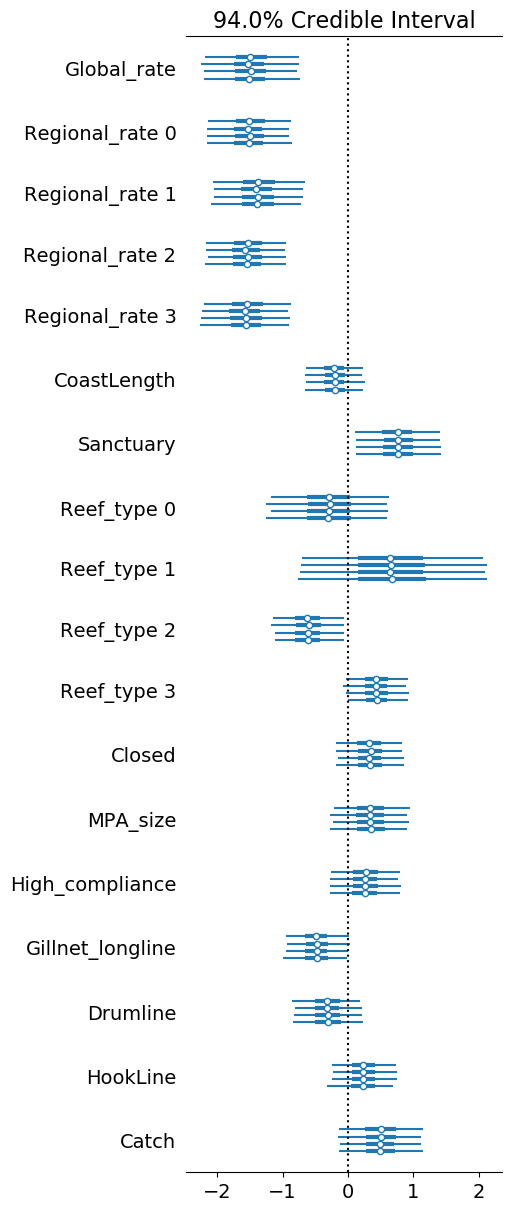

In [71]:
pm.forestplot(trace, varnames=varset[:12],figsize=(5, 12))
plt.axvline(0, linestyle=":", color="black")
plt.savefig('Figure_S2a_'+critter+'.jpg',dpi=300);

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


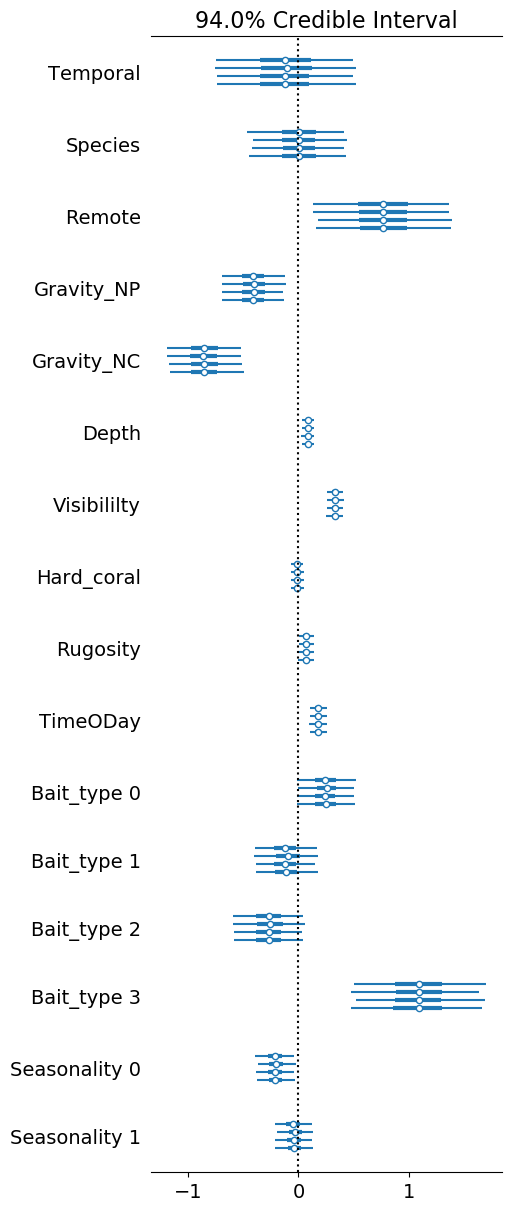

In [72]:
pm.forestplot(trace, varnames=varset[12:24],figsize=(5, 12))
plt.axvline(0, linestyle=":", color="black")
plt.savefig('Figure_S2b_'+critter+'.jpg',dpi=300);

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


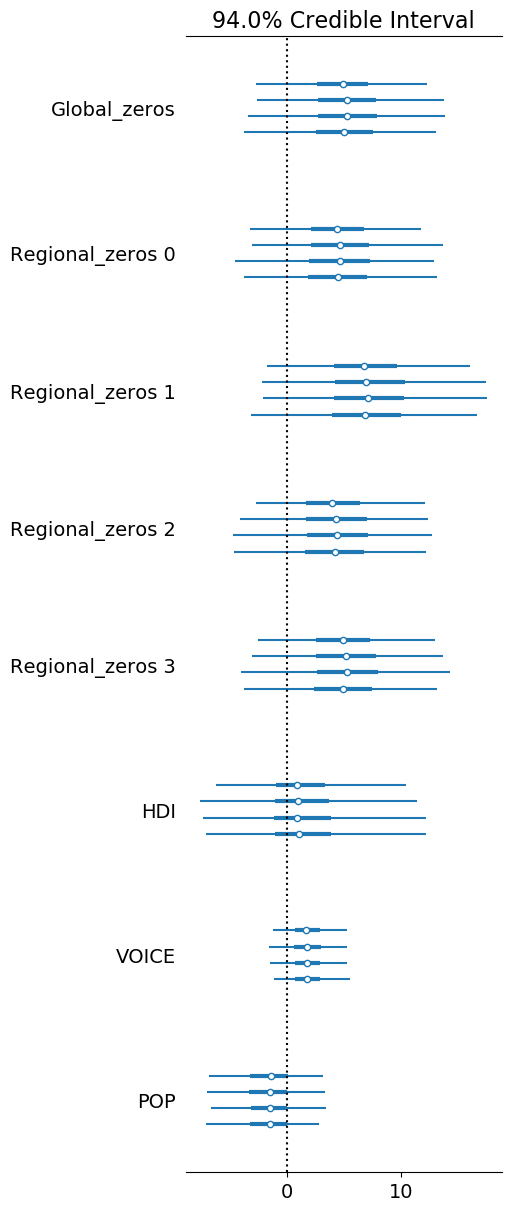

In [73]:
pm.forestplot(trace, varnames=varset[24:],figsize=(5, 12))
plt.axvline(0, linestyle=":", color="black")
plt.savefig('Figure_S2c_'+critter+'.jpg',dpi=300);

## Export other models

In [74]:
# Export partial null model results
results = pm.backends.tracetab.trace_to_dataframe(ZINB_partial_null_trace)
colnames = np.array(list(results.columns), dtype=object)
colnames[np.array([list(colnames).index(x) for x in grep('κ0',colnames)])] = np.array(['κ0_'+str(r) for r in Reef])
colnames[np.array([list(colnames).index(x) for x in grep('η0_z',colnames)])] = np.array(['η0z_'+l for l in Location])
colnames[np.array([list(colnames).index(x) for x in grep('η0_',colnames)])] = np.array(['η0_'+l for l in Location])
colnames[np.array([list(colnames).index(x) for x in grep('Reef_type',colnames)])] = np.array(['Reef_type_'+r for r in RTY[1:]])
colnames[np.array([list(colnames).index(x) for x in grep('Regional_rate',colnames)])] = np.array(['Regional_rate_'+r for r in Region])
results.columns = list(colnames)
# Drop reef-specific columns
results = results.drop(list(colnames[np.array([list(colnames).index(x) for x in grep('κ0',colnames)])]),axis=1)
# Export posteriors
results.to_csv(critter+'_ZINB_partial_null_results_.csv')
# Export summary statistics 
results.quantile((0.5,.25,.975)).rename(index={0.5: 'Median',0.25: 'Low 95',0.975: 'Upp 95'}).to_csv(critter+'_ZINB_partial_null_summary_stats_.csv')

In [75]:
# Export partial null model results
results = pm.backends.tracetab.trace_to_dataframe(ZINB_full_count_trace)
colnames = np.array(list(results.columns), dtype=object)
colnames[np.array([list(colnames).index(x) for x in grep('κ0',colnames)])] = np.array(['κ0_'+str(r) for r in Reef])
colnames[np.array([list(colnames).index(x) for x in grep('η0_z',colnames)])] = np.array(['η0z_'+l for l in Location])
colnames[np.array([list(colnames).index(x) for x in grep('η0_',colnames)])] = np.array(['η0_'+l for l in Location])
colnames[np.array([list(colnames).index(x) for x in grep('Reef_type',colnames)])] = np.array(['Reef_type_'+r for r in RTY[1:]])
colnames[np.array([list(colnames).index(x) for x in grep('Regional_rate',colnames)])] = np.array(['Regional_rate_'+r for r in Region])
results.columns = list(colnames)
# Drop reef-specific columns
results = results.drop(list(colnames[np.array([list(colnames).index(x) for x in grep('κ0',colnames)])]),axis=1)
# Export posteriors
results.to_csv(critter+'_ZINB_full_count_results_.csv')
# Export summary statistics 
results.quantile((0.5,.25,.975)).rename(index={0.5: 'Median',0.25: 'Low 95',0.975: 'Upp 95'}).to_csv(critter+'_ZINB_full_count_summary_stats_.csv')

## Export full model

In [76]:
results = pm.backends.tracetab.trace_to_dataframe(trace)

In [77]:
# Edit column names
colnames = np.array(list(results.columns), dtype=object)

colnames[np.array([list(colnames).index(x) for x in grep('κ0',colnames)])] = np.array(['κ0_'+str(r) for r in Reef])
colnames[np.array([list(colnames).index(x) for x in grep('η0_z',colnames)])] = np.array(['η0z_'+l for l in Location])
colnames[np.array([list(colnames).index(x) for x in grep('η0_',colnames)])] = np.array(['η0_'+l for l in Location])

#colnames[np.array([list(colnames).index(x) for x in grep('Site_type',colnames)])] = np.array(['Site_type_'+s for s in STY[1:]])

#colnames[np.array([list(colnames).index(x) for x in grep('Bait_type',colnames)])] = np.array(['Bait_type'+b for b in BAIT[1:]])

colnames[np.array([list(colnames).index(x) for x in grep('Reef_type',colnames)])] = np.array(['Reef_type_'+r for r in RTY[1:]])

colnames[np.array([list(colnames).index(x) for x in grep('Regional_rate',colnames)])] = np.array(['Regional_rate_'+r for r in Region])

results.columns = list(colnames)

In [78]:
# Drop reef-specific columns
results = results.drop(list(colnames[np.array([list(colnames).index(x) for x in grep('κ0',colnames)])]),axis=1)
# Export posteriors
results.to_csv(critter+'_ZINB_results_.csv')
# Export summary statistics 
results.quantile((0.5,.25,.975)).rename(index={0.5: 'Median',0.25: 'Low 95',0.975: 'Upp 95'}).to_csv(critter+'_ZINB_summary_stats_.csv')

## Posterior predictive checks

In [79]:
ppc = pm.sample_posterior_predictive(ZINB_full_trace, model=ZINB_full)

100%|██████████| 20000/20000 [01:17<00:00, 258.22it/s]


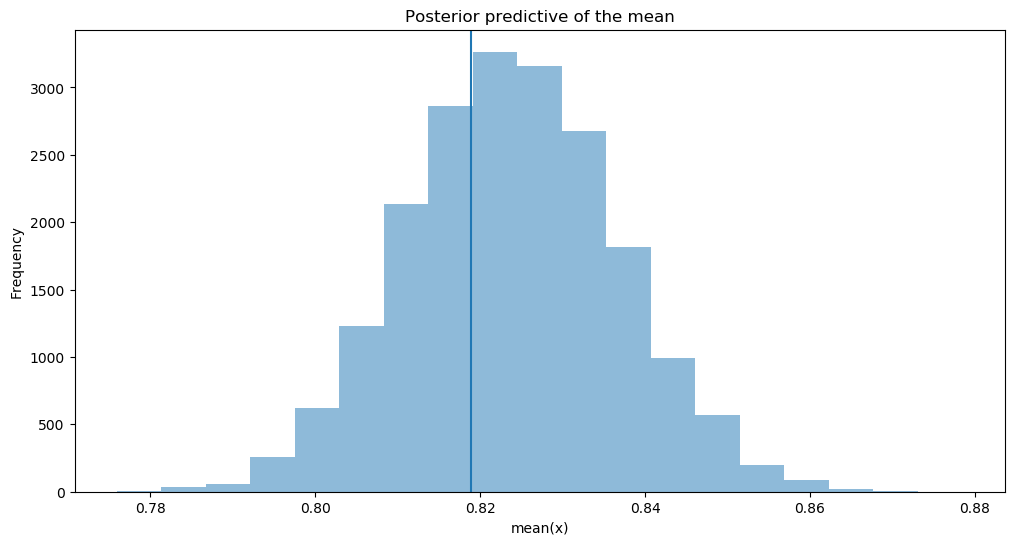

In [80]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['Yi']], bins=19, alpha=0.5)
ax.axvline(MaxN.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency')
plt.savefig('Figure_S4_Ex_'+critter+'.pdf');

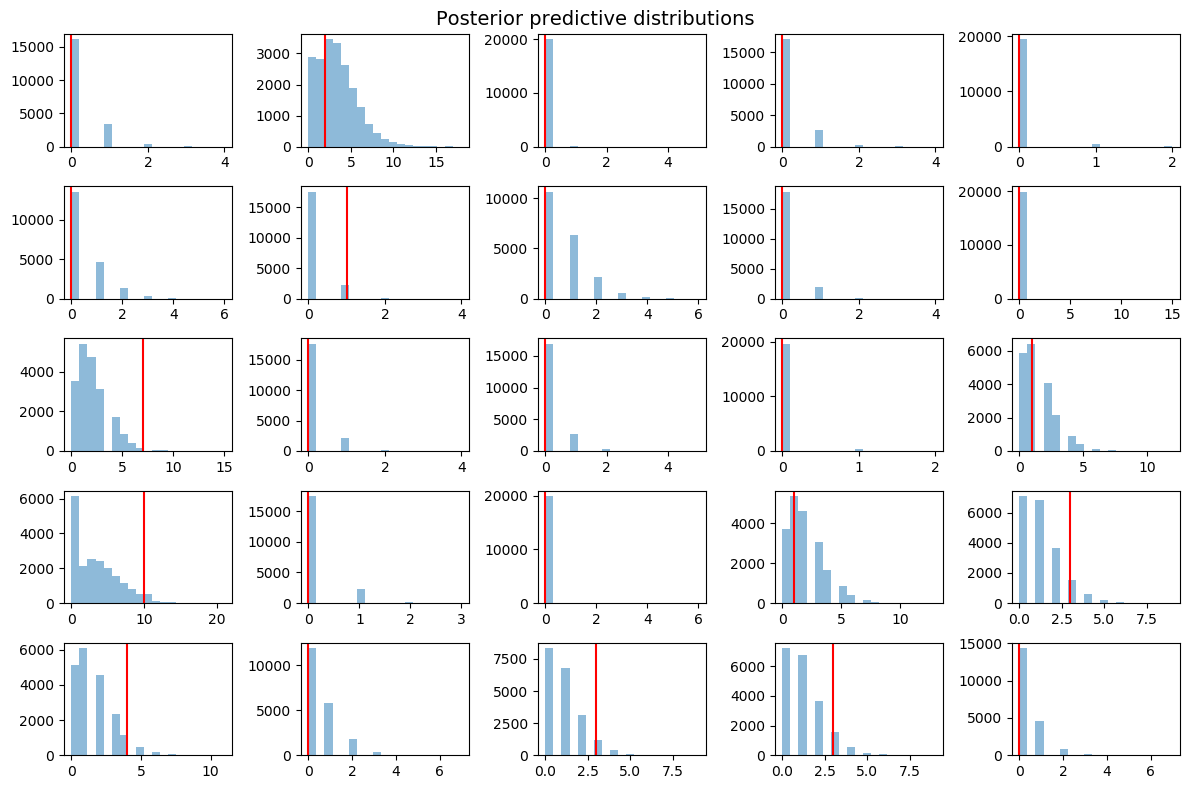

In [81]:
# Setup multipanel figure
nrows, ncols = 5, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
ax_ = axes.flatten()

# Transform ppc
PPC = ppc['Yi'].T
# Index random observations
indx = np.random.randint(0,len(PPC),size=nrows*ncols)

# Iterate over random samples from ppc
for i in range(nrows*ncols):
    ax1 = ax_[i]
    ax1.hist(PPC[indx[i]], bins=19, alpha=0.5)
    ax1.axvline(MaxN[indx[i]],c='red')

fig.tight_layout()
fig.suptitle('Posterior predictive distributions', fontsize=14)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure_S5_Ex'+critter+'.pdf');

In [82]:
tmp = 0
for i in range(nobs):
    #if MaxN[i]>np.mean(PPC[i]):
    if MaxN[i]>np.quantile(PPC[i],.95):
        tmp += 1
    else:
        pass

In [84]:
# Create tmp dataframe to sort observed MaxN values
tmpsort = pd.DataFrame({'indx':np.arange(len(MaxN)),'maxn':MaxN}).sort_values('maxn')

In [85]:
tmp = []
for i in range(nobs):
    #if MaxN[i]>np.mean(PPC[i]):
    if MaxN[i]>np.quantile(PPC[i],.95) or MaxN[i]<np.quantile(PPC[i],.05):
        tmp += [list(xdata.iloc[i].values)]
    else:
        pass
deets = np.array(tmp)
# Outside prediction rate
len(deets)/len(MaxN)

0.019980217606330366

In [86]:
tmp = []
for i in range(nobs):
    #if MaxN[i]>np.mean(PPC[i]):
    if MaxN[i]>np.quantile(PPC[i],.975) or MaxN[i]<np.quantile(PPC[i],.025):
        tmp += [list(xdata.iloc[i].values)]
    else:
        pass
deets = np.array(tmp)
# Outside prediction rate
len(deets)/len(MaxN)

0.011078140454995054

In [87]:
tmp = []
for i in range(nobs):
    #if MaxN[i]>np.mean(PPC[i]):
    if MaxN[i]>np.quantile(PPC[i],.75) or MaxN[i]<np.quantile(PPC[i],.25):
        tmp += [list(xdata.iloc[i].values)]
    else:
        pass
deets = np.array(tmp)
# Outside prediction rate

len(deets)/len(MaxN)

0.13339927464556545

In [88]:
xs = np.linspace(0,10,100)

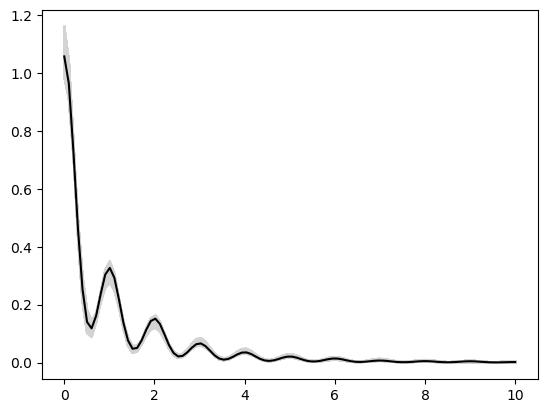

In [89]:
for p in PPC.T:
    plt.plot(xs,sp.stats.gaussian_kde(p)(xs),c='lightgrey')
plt.plot(xs,sp.stats.gaussian_kde(MaxN)(xs),c='black');
plt.savefig('Figure_ppdfit.pdf');

In [90]:
from collections import Counter

In [91]:
np.shape(tmp)[0]*np.shape(tmp)[1]

180047

In [92]:
# Get bin proportions from PPDs
tmp = PPC

out = []
maxmaxn = 10
xbin = np.linspace(0,maxmaxn,maxmaxn+1).astype(int)
for t in tmp:
    poo = [sum(t==i) for i in xbin]
    out += [poo/sum(poo)]


PlotBin = np.array([xbin]*len(tmp)).reshape(1,len(xbin)*len(tmp))[0]
PlotOut = np.array(out).reshape(PlotBin.shape)

PPDplot = pd.DataFrame({'Freq':PlotOut,'Count':PlotBin})

In [93]:
PPDplot.to_csv('PPD_bins.csv')

In [94]:
# Get observed proportions for MaxN
ObsBin = np.array([sum(MaxN==i) for i in xbin])
# Adjust for zero-inflation
ObsBin[0] = ObsBin[0]*(invlogit(np.median(trace['Global_zeros'])))
# Get corrected proportions
ObsOut = ObsBin/sum(ObsBin)

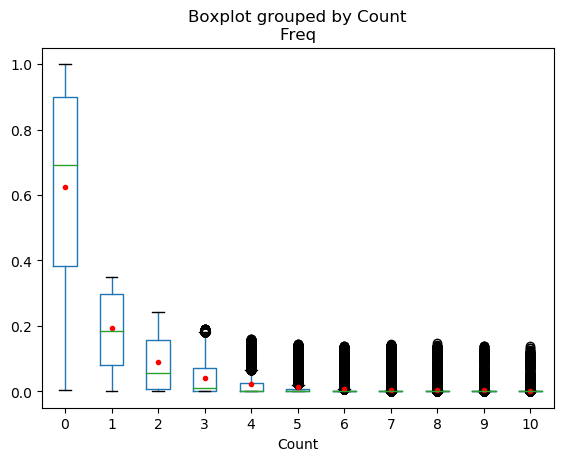

In [95]:
PPDplot.boxplot(column='Freq', by='Count', grid=False)
plt.plot(xbin+1,ObsOut,'r.')
#plt.title('Posterior predictive distribution')
plt.savefig('Figure_ppdfit_box.pdf');

# Results plots

In [96]:
# Rename parameters
p_presence = invlogit(results[colnames[np.array([list(colnames).index(x) for x in grep('η0z',colnames)])]])
p_presence.columns = list(Location)
p_presence = p_presence[p_presence.median().sort_values().index.values]
Plocation = p_presence.columns.values

### P(counts)

In [97]:
# Add sample sizes (nreefs) per country
Plocationz = [c+" ("+str(list(np.array(LocationR)[Ilr]).count(c))+")" for c in Plocation]

In [98]:
mpl.style.use('seaborn')

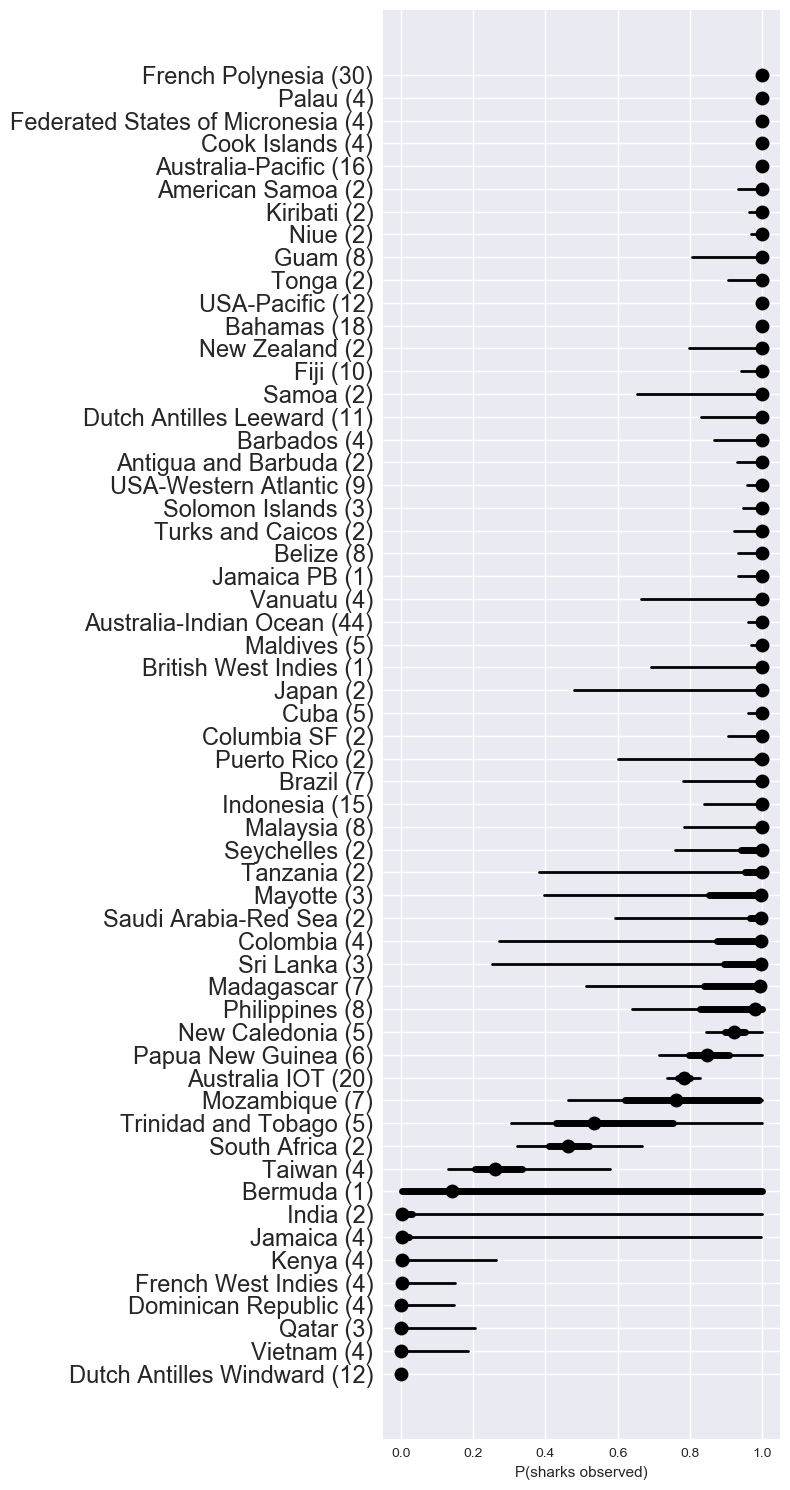

In [99]:
fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot(111)
[gelplot(ax,p_presence[Plocation[i]],i,csize=20,lwd50=5,lwd95=2) for i in range(nlocs)]
ax.set_yticks(range(nlocs))
ax.set_yticklabels(Plocationz,fontsize=17)
ax.set_xlabel('P(sharks observed)')
plt.tight_layout()
plt.savefig('ED_Figure_2.pdf');

### Ex(MaxN|pressence)

In [100]:
ex_abu = np.exp(results[colnames[np.array([list(colnames).index(x) for x in grep('η0_',colnames)])]])
ex_abu.columns = list(Location)
ex_abu = ex_abu[ex_abu.median().sort_values().index.values]
Elocation = ex_abu.columns.values

In [101]:
# Add sample sizes (nreefs) per country
Elocationz = [c+" ("+str(list(np.array(LocationR)[Ilr]).count(c))+")" for c in Elocation]

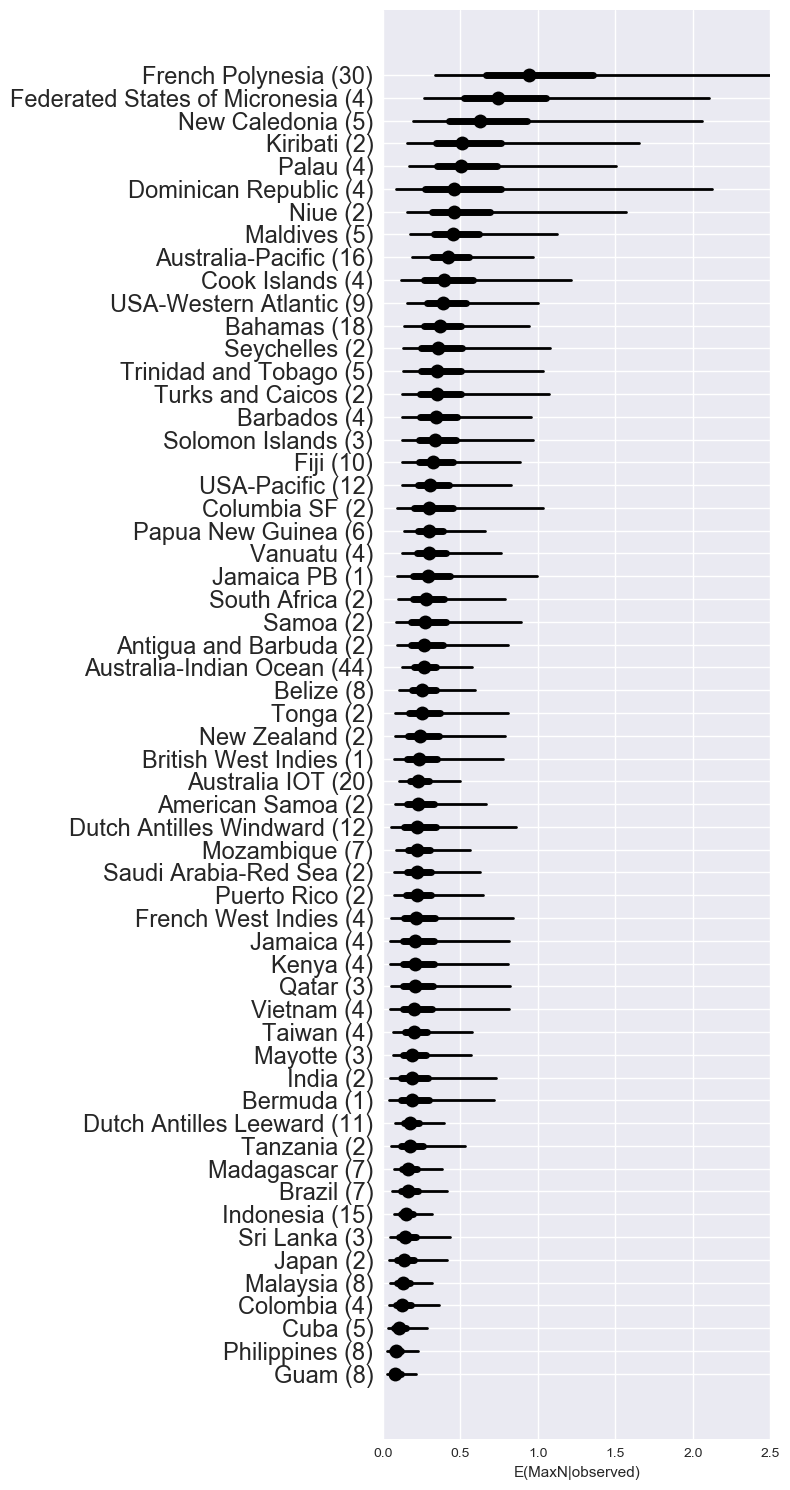

In [102]:
fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot(111)
[gelplot(ax,ex_abu[Elocation[i]],i,csize=20,lwd50=5,lwd95=2) for i in range(nlocs)]
ax.set_yticks(range(nlocs))
ax.set_xlim(0,2.5)
ax.set_yticklabels(Elocationz,fontsize=17)
ax.set_xlabel('E(MaxN|observed)')
plt.tight_layout()
plt.savefig('ED_Figure_3.pdf');

In [103]:
np.exp(np.percentile(results['Regional_rate_Western Pacific'].values, (50,25,97.5)))

array([0.20982724, 0.16555658, 0.4171421 ])

In [104]:
np.exp(np.percentile(results['Regional_rate_Western Atlantic'].values, (50,25,97.5)))

array([0.2195478 , 0.17671274, 0.43008354])

In [105]:
np.exp(np.percentile(results['Regional_rate_Central Pacific'].values, (50,25,97.5)))

array([0.24991692, 0.19769333, 0.53760076])

In [106]:
np.exp(np.percentile(results['Regional_rate_Indian Ocean'].values, (50,25,97.5)))

array([0.21345538, 0.17244453, 0.39781646])